In [4]:
import torch
from dataset import ImageDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torch.optim as optim
import torch.nn as nn
import numpy as np
import sys
from vit.vit import VisionTransformer
import time
import pandas as pd
from torchmetrics import Precision, Recall
import warnings
from torchvision.models import resnet18
warnings.filterwarnings('ignore')

from torchvision import transforms
from torchvision.transforms import functional as F
import pandas as pd
import albumentations as A


transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ], p=0.8),
    A.Rotate(limit=90, p=0.5),
    A.Resize(32, 32)
])

In [18]:
# from torchvision.models import resnet152
# class ResNet152WithDropout(nn.Module):
#     def __init__(self, num_classes=4, dropout_prob=0.5):
#         super(ResNet152WithDropout, self).__init__()
#         resnet = resnet152(pretrained=True)

#         resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#         resnet.fc = nn.Sequential(
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(resnet.fc.in_features, num_classes)
#         )



#         self.resnet = resnet

#     def forward(self, x):
#         return self.resnet(x)

# # Create an instance of the model
# model = ResNet152WithDropout(num_classes=4, dropout_prob=0.5)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/adam/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100.0%


In [22]:
# model = resnet18()
# model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# num_classes = 4
# model.fc = nn.Sequential(
#     nn.Dropout(0.6),  
#     nn.Linear(model.fc.in_features, num_classes)
# )

In [5]:
pd.options.mode.chained_assignment = 'warn'
torch.cuda.empty_cache()


model = VisionTransformer(image_size=32, in_channels=4, num_classes=4, hidden_dims=[16, 16], dropout_rate=0.6)

batch_size = 64

trainset = ImageDataset(data_path='train_data', transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=5)


testset =ImageDataset(data_path='validation_data')

testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=5)

model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


precisions = []
precisions_val = []


recalls = []
val_recalls = []

losses = []
val_losses = []



metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

metric_precision_val = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall_val = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

EPOCHS = 40


In [6]:
for epoch in range(EPOCHS):
    recall = []
    precision = []

    recall_val = []
    precision_val = []

    training_loss = []
    start_time = time.time()
    elapsed_time = 0
    model.train() 
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = data
    
        
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)


        metric_precision(outputs, labels)
        metric_recall(outputs, labels)



        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())

        if (i + 1) % 100 == 0 or i == len(trainloader) - 1:
            elapsed_time = time.time() - start_time
            batches_done = i + 1
            batches_total = len(trainloader)
            batches_remaining = batches_total - batches_done
            time_per_batch = elapsed_time / batches_done
            estimated_time_remaining = time_per_batch * batches_remaining

            elapsed_time_minutes = elapsed_time / 60
            estimated_time_remaining_minutes = estimated_time_remaining / 60

            progress_message = f'Batch {i}/{len(trainloader)},Remaining: {estimated_time_remaining_minutes:.2f}min'
            sys.stdout.write("\r" + progress_message)
            sys.stdout.flush()

        

 
    model.eval()  
    val_loss = []
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            labels = torch.Tensor(labels)
            inputs = inputs.to('cuda:0')
            labels = labels.to('cuda:0')


            outputs = model(inputs)
            val_loss_crt = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)

            metric_precision_val(outputs, labels)
            metric_recall_val(outputs, labels)


            val_loss.append(val_loss_crt.item())

    precision = metric_precision.compute()
    recall = metric_recall.compute()

    precision_val = metric_precision_val.compute()
    recall_val = metric_recall_val.compute()

    precisions.append(precision)
    precisions_val.append(precision_val)

    recalls.append(recall)
    val_recalls.append(recall_val)
    
    losses.append(np.mean(training_loss))
    val_losses.append(np.mean(val_loss))
    
    print(f'Epoch {epoch + 1}, Training loss: {np.mean(training_loss)} Validation Loss: {np.mean(val_loss)}')
    
    print(f'Epoch {epoch + 1}, Training Class 1: {precision[0]}, Class 2: {precision[1]}, Class 3: {precision[2]}, Class 4: {precision[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {precision_val[0]}, Class 2: {precision_val[1]}, Class 3: {precision_val[2]}, Class 4: {precision_val[3]}')

    print(f'Epoch {epoch + 1}, Training Class 1: {recall[0]}, Class 2: {recall[1]}, Class 3: {recall[2]}, Class 4: {recall[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {recall_val[0]}, Class 2: {recall_val[1]}, Class 3: {recall_val[2]}, Class 4: {recall_val[3]}')

    

print('Finished Training')
print('Finished Training')


Batch 3356/3357,Remaining: 0.00minEpoch 1, Training loss: 0.917046847746846 Validation Loss: 0.9045300366068317
Epoch 1, Training Class 1: 0.6523109078407288, Class 2: 0.5338716506958008, Class 3: 0.7016393542289734, Class 4: 0.6256760954856873
Epoch 1, Validation Class 1: 0.580686092376709, Class 2: 0.5693662762641907, Class 3: 0.7874720096588135, Class 4: 0.8110135197639465
Epoch 1, Training Class 1: 0.7616882920265198, Class 2: 0.4942280054092407, Class 3: 0.06176046282052994, Class 4: 0.6242856979370117
Epoch 1, Validation Class 1: 0.8782828450202942, Class 2: 0.5962626338005066, Class 3: 0.11851851642131805, Class 4: 0.42595958709716797
Batch 3356/3357,Remaining: 0.00minEpoch 2, Training loss: 0.8303823838959785 Validation Loss: 0.8202604844058198
Epoch 2, Training Class 1: 0.6719933152198792, Class 2: 0.5572630167007446, Class 3: 0.6959654092788696, Class 4: 0.6491308212280273
Epoch 2, Validation Class 1: 0.6377127170562744, Class 2: 0.5886380672454834, Class 3: 0.404667973518371

In [7]:
torch.save(model.state_dict(),'models/model_vit9.pth')
df = pd.DataFrame()
df['loss'] = np.array(losses)
df['val_loss'] = np.array(val_losses)

df['recall'] = [list(recall.cpu().numpy()) for recall in recalls]
df['val_recall'] = [list(val_recall.cpu().numpy()) for val_recall in val_recalls]

df['precision'] = [list(precision.cpu().numpy()) for precision in precisions] 
df['val_precision'] = [list(val_precision.cpu().numpy()) for val_precision in precisions_val]

df.to_csv('results/results_vit9.csv', index=False)

In [8]:
df = pd.read_csv('results/results_vit9.csv')
df.head()

,loss,val_loss,recall,val_recall,precision,val_precision
0,0.917047,0.904530,"[0.7616883, 0.494228, 0.061760463, 0.6242857]","[0.87828285, 0.59626263, 0.11851852, 0.4259596]","[0.6523109, 0.53387165, 0.70163935, 0.6256761]","[0.5806861, 0.5693663, 0.787472, 0.8110135]"
1,0.830382,0.820260,"[0.7676191, 0.5295527, 0.10454545, 0.64419913]","[0.83267677, 0.57023567, 0.20723906, 0.56239057]","[0.6719933, 0.557263, 0.6959654, 0.6491308]","[0.6377127, 0.58863807, 0.40466797, 0.72629637]"
2,0.796253,0.759868,"[0.77262145, 0.5458538, 0.14612794, 0.6574218]","[0.8235129, 0.6050393, 0.26161617, 0.5811672]","[0.685276, 0.5722188, 0.65743345, 0.65980524]","[0.6656295, 0.5936853, 0.45976332, 0.73866653]"
3,0.772472,0.774443,"[0.77594876, 0.5562085, 0.17907648, 0.66712844]","[0.82984847, 0.5897643, 0.31085858, 0.607702]","[0.69589794, 0.5820633, 0.63878524, 0.66622716]","[0.6766694, 0.6070141, 0.41569114, 0.7345923]"
4,0.754427,0.765575,"[0.77898127, 0.56452525, 0.20481962, 0.6744416]","[0.83373064, 0.57533336, 0.33353534, 0.6293131]","[0.70432484, 0.58970827, 0.6298926, 0.6716271]","[0.68237257, 0.616749, 0.4245671, 0.72603464]"


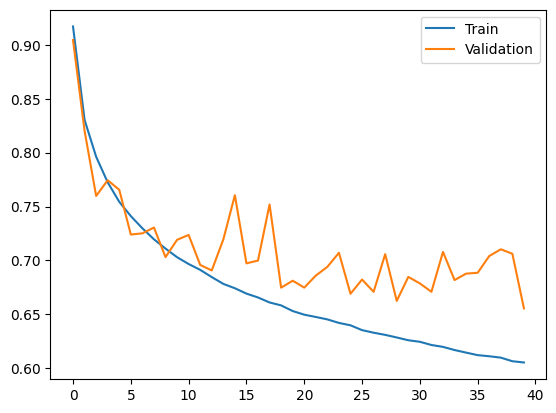

In [9]:
plt.plot(df['loss'], label='Train')
plt.plot(df['val_loss'], label='Validation')
plt.legend()
plt.show()